In [1]:
# %load_ext tensorboard
import datetime
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import sklearn.metrics
import seaborn as sn
import pandas as pd

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4303346901348324755
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15249022533315800843
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1391427175
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16816503154889002129
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3941653073593920263
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
import tensorflow as tf
print("Num CPUUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num CPUUs Available:  1
Num GPUs Available:  1


In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
n_epoch = 5

IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [5]:
TRAINING_DIR = "dataset"
VALIDATION_DIR = "dataset_kue"
datagen = ImageDataGenerator(
#     rescale = 1./127.5,
    rescale = 1./255. ,
    # rotation_range=40,
    # featurewise_center=True,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.4,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.1,
      )

print("Loading training data...\t\t", end='')
train_generator = datagen.flow_from_directory(
	  TRAINING_DIR,
  	target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',

)

print("Loading validation data...\t\t", end='')
validation_generator = datagen.flow_from_directory(
  	TRAINING_DIR,
#     VALIDATION_DIR,
	  target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
)



Loading training data...		Found 254 images belonging to 3 classes.
Loading validation data...		Found 27 images belonging to 3 classes.


In [6]:
TEST_DIR = "dataset_kue_test_2"

test_generator = ImageDataGenerator(
    rescale = 1./255. ,
#     rescale = 1./127.5 ,
)
print("Loading testing data...\t\t", end='')
test_data = test_generator.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

# image = tf.keras.preprocessing.image.load_img(TEST_DIR)
# test_arr = keras.preprocessing.image.img_to_array(image)
# test_arr = np.array([input_arr])

Loading testing data...		Found 18 images belonging to 3 classes.


In [7]:
class_names = []
for a in train_generator.class_indices:
    class_names.append(a)
print(class_names)

['kue_dadar_gulung', 'kue_klepon', 'kue_lumpur']


In [8]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((16, 224, 224, 3), (16, 3))

In [9]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'kue_dadar_gulung': 0, 'kue_klepon': 1, 'kue_lumpur': 2}


In [10]:
base_model = tf.keras.applications.MobileNetV2(
    IMAGE_SHAPE,
    include_top=False,
    weights='imagenet',
)
base_model.trainable = False
# base_model.summary()

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()


prediction_layer2 = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')


In [12]:
inputs = tf.keras.Input(shape=IMAGE_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer2(x)
model = tf.keras.Model(inputs, outputs)

# l_rate = 0.0001
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
# %tensorboard --logdir logs

# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# history = data_prep.fit(train_generator,
#                     steps_per_epoch=len(train_generator), 
# #                     steps_per_epoch=100, 
#                     epochs=10, 
#                     validation_data = validation_generator, 
#                     validation_steps=len(validation_generator),
# #                     validation_steps=100,
# #                     batch_size=32,
#                     # verbose=1,
#                     # callbacks=[es_callback],
# #                     callbacks=[cm_callback],
#                     )

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=n_epoch, 
                    validation_data = validation_generator, 
                    validation_steps=len(validation_generator),
                    # verbose=1,
                    # callbacks=[es_callback],
#                     callbacks=[cm_callback],
                    )

Epoch 1/5
16/16 [==============================] - 5s 289ms/step - loss: 0.6408 - accuracy: 0.7205 - val_loss: 0.2560 - val_accuracy: 0.9259
Epoch 2/5
16/16 [==============================] - 2s 119ms/step - loss: 0.1182 - accuracy: 0.9882 - val_loss: 0.1021 - val_accuracy: 0.9630
Epoch 3/5
16/16 [==============================] - 2s 122ms/step - loss: 0.0449 - accuracy: 1.0000 - val_loss: 0.0463 - val_accuracy: 1.0000
Epoch 4/5
16/16 [==============================] - 2s 118ms/step - loss: 0.0263 - accuracy: 0.9961 - val_loss: 0.0354 - val_accuracy: 1.0000
Epoch 5/5
16/16 [==============================] - 2s 119ms/step - loss: 0.0250 - accuracy: 1.0000 - val_loss: 0.0292 - val_accuracy: 1.0000


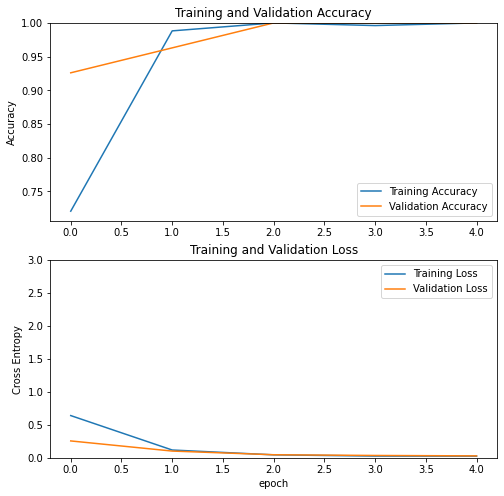

In [14]:
# Before fine tunning

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [15]:
print("Model evaluate:")
results = model.evaluate(test_data)

Model evaluate:
2/2 [==============================] - 0s 213ms/step - loss: 0.0692 - accuracy: 1.0000


Confusion Matrix
[[5 0 1]
 [1 4 1]
 [0 2 4]]


<AxesSubplot:>

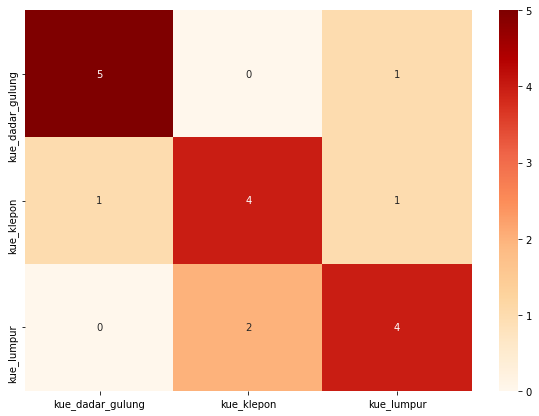

In [47]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_data,  BATCH_SIZE // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1) 
conn = confusion_matrix(test_data.classes, y_pred)
print('Confusion Matrix')
print(conn)
df_cm = pd.DataFrame(conn, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="OrRd")

In [ ]:
# saved_model_dir = 'model_final'
# tf.saved_model.save(model, saved_model_dir)

# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# tflite_model = converter.convert()

# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

IndexError: index 16 is out of bounds for axis 0 with size 16

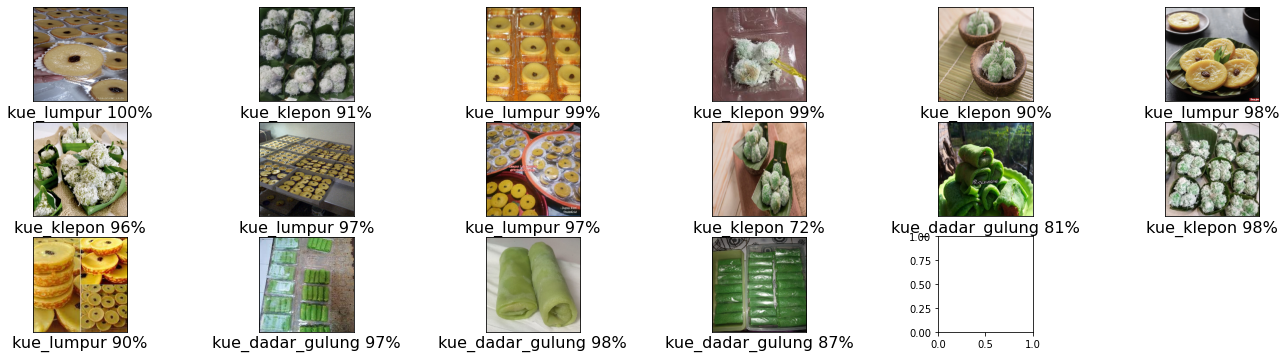

In [26]:
num_rows = 3
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
# class_names = ['kue_cenil', 'kue_clorot', 'kue_mendut', 'dadar gulung', 'klepon', 'lapis', 'lumpur', 'serabi']


def plot_image(i, predictions_array, true_label, img, target):
  true_label, img = true_label[i], img[i]
  wh = np.where(true_label)
  npa = np.int64(wh[0]).astype(int)

  predicted_label = np.argmax(predictions_array)

#   if npa[np.array(0)] != target:
#     return
#   if predicted_label == target:
#         if npa[np.array(0)] == target:
#             return

#   print(predicted_label)
#   print(npa[np.array(0)])

  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                ),
             fontsize=16,
             )

target = 7
x, y = test_data.next()
for i in range(64):
  predictions = model.predict(x)
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y, x, target)

plt.tight_layout()
plt.show()


ValueError: num must be 1 <= num <= 8, not 9

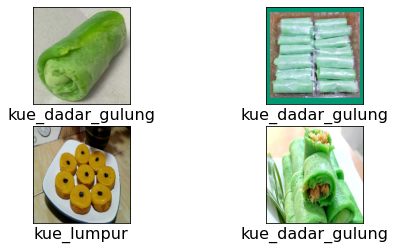

In [25]:
def show_image(i, true_label, img, target=0):
  true_label, img = true_label[i], img[i]
  wh = np.where(true_label)
  npa = np.int64(wh[0]).astype(int)

  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  plt.xlabel("{}".format(class_names[npa[0]],
                                ),
             fontsize=16,
             )

num_rows = 2
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

x, y = train_generator.next()
for i in range(64):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  show_image(i, y, x)

plt.tight_layout()
plt.show()